In [1]:
# Imports
import math
import os

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

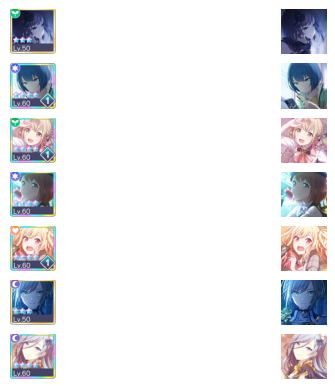

In [2]:
# Some manually matched thumbnails
matching_images = [
    ("./img/ena.png", "./thumbnails/res019_no014_after_training.png"),
    ("./img/haruka.png", "./thumbnails/res006_no017_normal.png"),
    ("./img/kohane.png", "./thumbnails/res009_no007_after_training.png"),
    ("./img/minori.png", "./thumbnails/res005_no015_after_training.png"),
    ("./img/saki.png", "./thumbnails/res002_no015_normal.png"),
    ("./img/shiho.png", "./thumbnails/res004_no016_after_training.png"),
    ("./img/shizuku.png", "./thumbnails/res008_no008_after_training.png"),
]

cols = 2
rows = len(matching_images)

fig, axes = plt.subplots(rows, cols)

for i in range(rows):
    extracted = cv.imread(matching_images[i][0])
    axes[i, 0].set_axis_off()
    axes[i, 0].imshow(extracted[..., ::-1])

    reference = cv.imread(matching_images[i][1])
    axes[i, 1].set_axis_off()
    axes[i, 1].imshow(reference[..., ::-1])

In [3]:
# Function to compute the colour histogram for an image
# Can pass in the mask and number of hue/saturation bins as needed
def compute_histogram(img_bgr, mask = None, bins_h = 50, bins_s = 60):
    img_hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
    hist_size = [bins_h, bins_s]

    # Hue ranges from 0 to 179, saturation from 0 to 255
    ranges_h = [0, 180]
    ranges_s = [0, 256]
    ranges = ranges_h + ranges_s

    # Use the 0th and 1st channels
    channels = [0, 1]

    # Calculate and normalise the histogram for the image
    hist = cv.calcHist([img_hsv], channels, mask, hist_size, ranges, accumulate=False)
    hist_normalised = cv.normalize(hist, hist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

    return hist_normalised

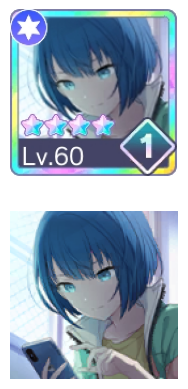

In [4]:
# Computing colour histogram for Haruka's thumbnail
img_haruka_ext = cv.imread(matching_images[1][0])
img_haruka_ref = cv.imread(matching_images[1][1])

fig, axes = plt.subplots(2, 1)
axes[0].set_axis_off()
axes[0].imshow(img_haruka_ext[..., ::-1])

axes[1].set_axis_off()
axes[1].imshow(img_haruka_ref[..., ::-1])

Extracted vs. Reference: 0.5941306781871591


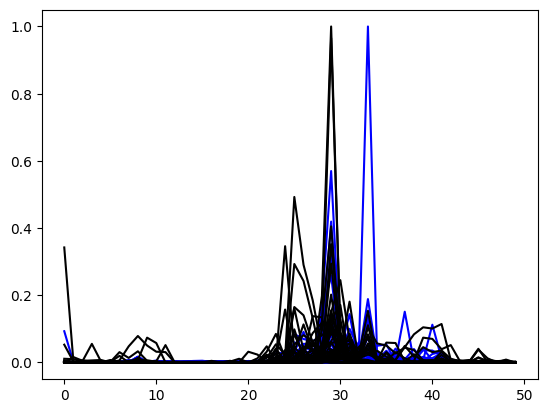

In [5]:
# Calculating the histogram as-is
hist_haruka_ext = compute_histogram(img_haruka_ext)
hist_haruka_ref = compute_histogram(img_haruka_ref)

# These histograms aren't too useful though, since there's other parts (rarity stars, border etc.) that contribute to the colours
cmp_ext_ref = cv.compareHist(hist_haruka_ext, hist_haruka_ref, cv.HISTCMP_CORREL)
print("Extracted vs. Reference:", cmp_ext_ref)

plt.plot(hist_haruka_ext, color=(0, 0, 1))
plt.plot(hist_haruka_ref, color=(0, 0, 0))
plt.show()

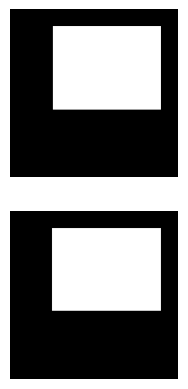

In [6]:
# Using the images as-is isn't particularly helpful, since the extracted thumbnail has parts that contribute to the colour
# So we need to use a mask / crop the image
#
# Manually cropping Haruka's thumbnail (157x157px) shows that we need to remove:
# - ~10px from top (6.3%)
# - ~60px from bottom (38.2%)
# - ~35px from left (22.3%)
# - ~10px from right (6.3%)
#
# To make calculations easier, these can be rounded up to:
# - 10% from top
# - 40% from bottom
# - 25% from left
# - 10% from right
def get_thumbnail_mask(img_thumbnail, top=0.1, bot=0.4, left=0.25, right=0.1):
    (h, w, _) = img_thumbnail.shape
    
    y_top = math.ceil(h * top)
    y_bot = h - math.ceil(h * bot)

    x_left = math.ceil(w * left)
    x_right = w - math.ceil(w * right)

    mask = np.zeros((h, w), np.uint8)
    mask[y_top:y_bot, x_left:x_right] = 255

    return mask

mask_haruka_ext = get_thumbnail_mask(img_haruka_ext)
mask_haruka_ref = get_thumbnail_mask(img_haruka_ref)

fig, axes = plt.subplots(2)
axes[0].set_axis_off()
axes[0].imshow(mask_haruka_ext, cmap="gray")

axes[1].set_axis_off()
axes[1].imshow(mask_haruka_ref, cmap="gray")

Extracted vs. Reference: 0.9192015106027246


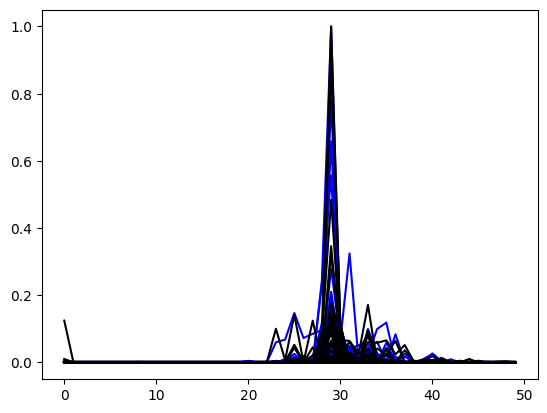

In [7]:
# Trying to find the colour histograms again, this time with the mask
hist_haruka_ext_masked = compute_histogram(img_haruka_ext, mask_haruka_ext)
hist_haruka_ref_masked = compute_histogram(img_haruka_ref, mask_haruka_ref)

# These result in a much better match
cmp_ext_ref_masked = cv.compareHist(hist_haruka_ext_masked, hist_haruka_ref_masked, cv.HISTCMP_CORREL)
print("Extracted vs. Reference:", cmp_ext_ref_masked)

plt.plot(hist_haruka_ext_masked, color=(0, 0, 1))
plt.plot(hist_haruka_ref_masked, color=(0, 0, 0))
plt.show()

In [8]:
# Building a "database" of histograms for all the reference images
# In practice, this would only need to be calculated for new images or if the mask has changed
hist_database = []
for root, _, filenames in os.walk("./thumbnails"):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        img_ref = cv.imread(filepath)
        mask_ref = get_thumbnail_mask(img_ref)
        hist_ref = compute_histogram(img_ref, mask_ref)

        hist_database.append((filepath, hist_ref))

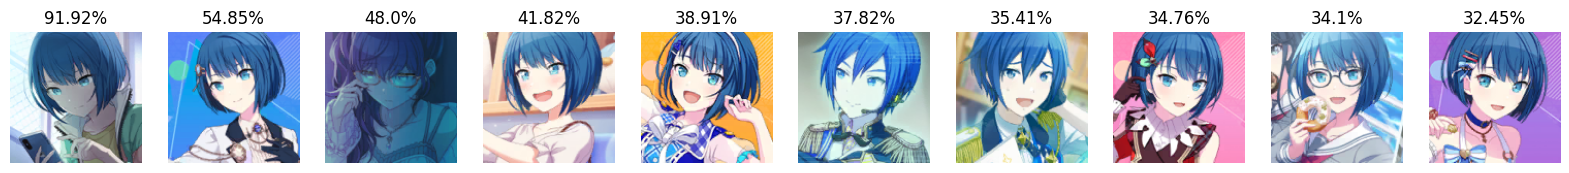

In [9]:
# Now try comparing Haruka's extracted histogram against the entire database, and find the 10 best matches
# This runs very quickly, which is ideal for the usecase of importing thumbnails from a screenshot
cmp_haruka_ext = []
for filepath, hist_ref in hist_database:
    cmp_ext_ref = cv.compareHist(hist_haruka_ext_masked, hist_ref, cv.HISTCMP_CORREL)
    cmp_haruka_ext.append((filepath, cmp_ext_ref))

cmp_haruka_ext.sort(key=lambda x: x[1], reverse=True)

max_matches = 10
fig, axes = plt.subplots(1, max_matches, figsize=(20, 10))

for i in range(max_matches):
    (filepath, cmp) = cmp_haruka_ext[i]
    img_ref = cv.imread(filepath)

    axes[i].set_axis_off()
    axes[i].set_title("{}%".format(round(cmp * 100, 2)))
    axes[i].imshow(img_ref[..., ::-1])

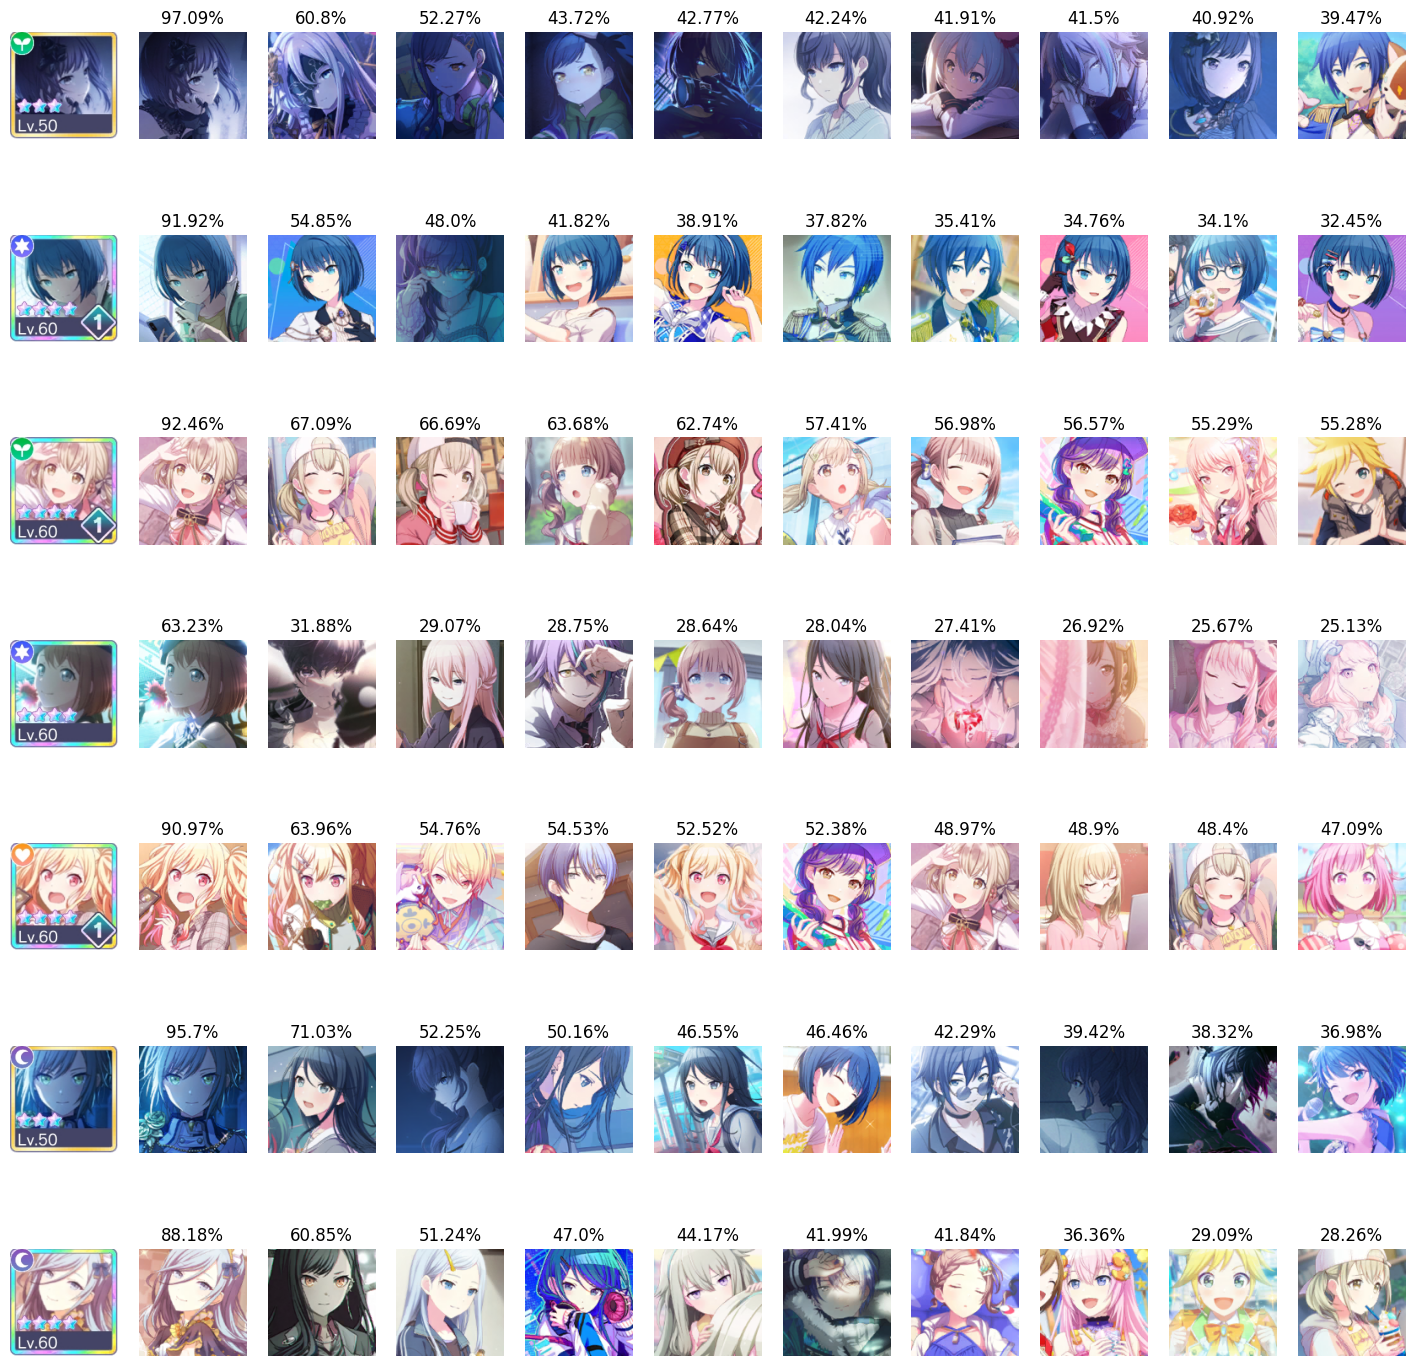

In [10]:
# Turning this into a general method for convenience
def find_top_n_thumbnails(img_ext, hist_database, n):
    mask_ext = get_thumbnail_mask(img_ext)
    hist_ext = compute_histogram(img_ext, mask_ext)

    cmp_values = []
    for filepath, hist_ref in hist_database:
        cmp = cv.compareHist(hist_ext, hist_ref, cv.HISTCMP_CORREL)
        cmp_values.append((filepath, cmp))

    cmp_values.sort(key=lambda x: x[1], reverse=True)
    return cmp_values[:n]

# Then applying it to all of the thumbnails loaded above
# While there are no mismatches, it seemed to have trouble with Minori's thumbnail
max_matches = 10

rows = len(matching_images)
cols = 1 + max_matches

fig, axes = plt.subplots(rows, cols, figsize=(18, 18))

for i in range(rows):
    img_ext = cv.imread(matching_images[i][0])
    cmp_values = find_top_n_thumbnails(img_ext, hist_database, max_matches)

    axes[i, 0].set_axis_off()
    axes[i, 0].imshow(img_ext[..., ::-1])

    for j in range(1, cols):
        (filepath_match, cmp_value) = cmp_values[j-1]
        img_match = cv.imread(filepath_match)

        axes[i, j].set_axis_off()
        axes[i, j].set_title("{}%".format(round(cmp_value * 100, 2)))
        axes[i, j].imshow(img_match[..., ::-1])